In [1]:
using Revise

In [2]:
using DFTK

┌ Info: Precompiling DFTK [acf6eb54-70d9-11e9-0013-234b7a5f5337]
└ @ Base loading.jl:1342


In [3]:
using Plots
using Unitful
using UnitfulAtomic

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1342


In [4]:
# 1. Define lattice and atomic positions
a = 5.431u"angstrom"          # Silicon lattice constant
lattice = a / 2 * [[0 1 1.];  # Silicon lattice vectors
                   [1 0 1.];  # specified column by column
                   [1 1 0.]]

3×3 Matrix{Quantity{Float64, 𝐋, Unitful.FreeUnits{(Å,), 𝐋, nothing}}}:
    0.0 Å  2.7155 Å  2.7155 Å
 2.7155 Å     0.0 Å  2.7155 Å
 2.7155 Å  2.7155 Å     0.0 Å

In [5]:
# Load HGH pseudopotential for Silicon
Si = ElementPsp(:Si, psp=load_psp("hgh/lda/Si-q4"))

ElementPsp(Si, psp=hgh/lda/si-q4)

In [13]:
# Specify type and positions of atoms
atoms = [Si => [ones(3)/8, -ones(3)/8]]

1-element Vector{Pair{ElementPsp, Vector{Vector{Float64}}}}:
 ElementPsp(Si, psp=hgh/lda/si-q4) => [[0.125, 0.125, 0.125], [-0.125, -0.125, -0.125]]

In [54]:
# 2. Select model and basis
model = model_LDA(lattice, atoms)

Model(lda_xc_teter93, 3D):
    lattice (in Bohr)    : [0         , 5.13155   , 5.13155   ]
                           [5.13155   , 0         , 5.13155   ]
                           [5.13155   , 5.13155   , 0         ]
    unit cell volume     : 270.26 Bohr³

    atoms                : Si₂
    atom potentials      : ElementPsp(Si, psp=hgh/lda/si-q4)

    num. electrons       : 8
    spin polarization    : none
    temperature          : 0 Ha

    terms                : Kinetic()
                           AtomicLocal()
                           AtomicNonlocal()
                           Ewald()
                           PspCorrection()
                           Hartree()
                           Xc(:lda_xc_teter93)

In [55]:
model.term_types[1]

Kinetic()

In [56]:
kgrid = [4, 4, 4]     # k-point grid (Regular Monkhorst-Pack grid)
Ecut = 7              # kinetic energy cutoff
# Ecut = 190.5u"eV"  # Could also use eV or other energy-compatible units
basis = PlaneWaveBasis(model; Ecut, kgrid)
# Note the implicit passing of keyword arguments here:
# this is equivalent to PlaneWaveBasis(model; Ecut=Ecut, kgrid=kgrid)

PlaneWaveBasis discretization:
    Ecut                 : 7.0 Ha
    fft_size             : (20, 20, 20)
    kgrid type           : Monkhorst-Pack
    kgrid                : [4, 4, 4]
    kshift               : [0.5, 0.5, 0.5]
    num. irred. kpoints  : 10

    Discretized Model(lda_xc_teter93, 3D):
        lattice (in Bohr)    : [0         , 5.13155   , 5.13155   ]
                               [5.13155   , 0         , 5.13155   ]
                               [5.13155   , 5.13155   , 0         ]
        unit cell volume     : 270.26 Bohr³
    
        atoms                : Si₂
        atom potentials      : ElementPsp(Si, psp=hgh/lda/si-q4)
    
        num. electrons       : 8
        spin polarization    : none
        temperature          : 0 Ha
    
        terms                : Kinetic()
                               AtomicLocal()
                               AtomicNonlocal()
                               Ewald()
                               PspCorrection()
           

In [57]:
[k.coordinate for k in basis.kpoints] #irreducible kpoints after symmetrization

10-element Vector{StaticArrays.SVector{3, Float64}}:
 [0.125, 0.125, 0.125]
 [0.375, 0.125, 0.125]
 [-0.375, 0.125, 0.125]
 [-0.125, 0.125, 0.125]
 [0.375, 0.375, 0.125]
 [-0.375, 0.375, 0.125]
 [-0.125, 0.375, 0.125]
 [-0.375, -0.375, 0.125]
 [0.375, 0.375, 0.375]
 [-0.375, 0.375, 0.375]

In [58]:
[length(k.G_vectors) for k in basis.kpoints] #number of G_vectors for each kpoint, for comparison 7^3 = 343

10-element Vector{Int64}:
 250
 243
 241
 237
 237
 238
 240
 236
 235
 240

In [59]:
[typeof(term) for term in basis.terms]

7-element Vector{DataType}:
 DFTK.TermKinetic
 DFTK.TermAtomicLocal
 DFTK.TermAtomicNonlocal
 DFTK.TermEwald
 DFTK.TermPspCorrection
 DFTK.TermHartree
 DFTK.TermXc

In [60]:
[length(e) for e in basis.terms[1].kinetic_energies] #how much kinetic energies for each kpoint
#conclusion : one kinetic energy for one (k, G)

10-element Vector{Int64}:
 250
 243
 241
 237
 237
 238
 240
 236
 235
 240

In [61]:
H=Hamiltonian(basis, ρ=guess_density(basis))
length(H.blocks)

10

In [62]:
[size(b) for b in H.blocks]

10-element Vector{Tuple{Int64, Int64}}:
 (250, 250)
 (243, 243)
 (241, 241)
 (237, 237)
 (237, 237)
 (238, 238)
 (240, 240)
 (236, 236)
 (235, 235)
 (240, 240)

In [63]:
# 3. Run the SCF procedure to obtain the ground state
scfres = self_consistent_field(basis, tol=1e-8);

n     Energy            Eₙ-Eₙ₋₁     ρout-ρin   α      Diag
---   ---------------   ---------   --------   ----   ----
  1   -7.905206970359         NaN   1.95e-01   0.80    4.1
  2   -7.909824304470   -4.62e-03   2.98e-02   0.80    1.0
  3   -7.910051972540   -2.28e-04   3.05e-03   0.80    3.1
  4   -7.910052832438   -8.60e-07   4.76e-04   0.80    2.4
  5   -7.910052852336   -1.99e-08   4.02e-05   0.80    2.0
  6   -7.910052854036   -1.70e-09   4.53e-06   0.80    3.1


In [64]:
hcat(scfres.eigenvalues...)

7×10 Matrix{Float64}:
 -0.170182  -0.131801   -0.0883282  …  -0.0562607  -0.11494    -0.0700169
  0.201343   0.0909036   0.0122924      0.0111144   0.0420614   0.0176496
  0.249295   0.174773    0.176137       0.132964    0.220114    0.11233
  0.249295   0.231428    0.20237        0.161043    0.220114    0.190456
  0.350986   0.360027    0.340134       0.291807    0.320727    0.327376
  0.36997    0.395897    0.389483   …   0.331814    0.38819     0.460242
  0.36997    0.401676    0.412474       0.565533    0.38819     0.462717

Computing bands along kpath:
       Γ -> X -> U  and  K -> Γ -> L -> W -> X


Diagonalising Hamiltonian kblocks: 100%|████████████████| Time: 0:00:00


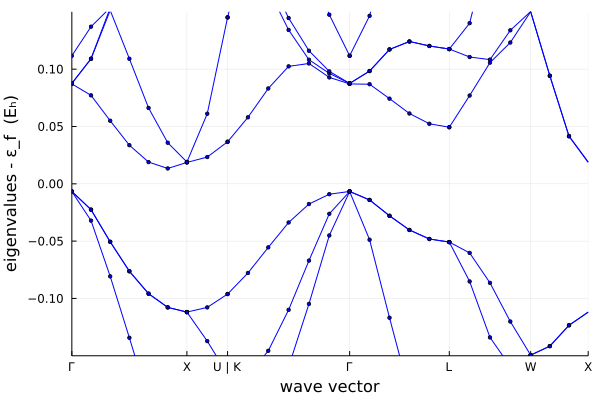

In [65]:
plot_bandstructure(scfres; kline_density=10)